In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [5]:
class Node:
    def __init__(self, feature=None, value=None, gain=None, threshold=None, left_node=None, right_node=None):
        self.feature=feature
        self.value=value
        self.gain=gain
        self.threshold=threshold
        self.left_node=left_node
        self.right_node=right_node

In [15]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def entropy(self, data):
        counts = np.bincount(data)
        probabilities = counts / len(data)
        entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        return entropy

    def IG(self, y, y_left, y_right):
        p = len(y_left) / len(y)
        return self.entropy(y) - p * self.entropy(y_left) - (1 - p) * self.entropy(y_right)

    def best_split(self, x, y):
        best_split = {}
        best_info_gain = -1
        _, n_cols = x.shape
        
        for feature_index in range(n_cols):
            feature_values = x[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) > 0 and len(y_right) > 0:
                    info_gain = self.IG(y, y_left, y_right)
                    if info_gain > best_info_gain:
                        best_split = {
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'left_mask': left_mask,
                            'right_mask': right_mask,
                            'gain': info_gain
                        }
                        best_info_gain = info_gain

        if best_split:
            print(f"Selected feature {best_split['feature_index']} with threshold {best_split['threshold']} as a decision node")
        return best_split
    
    def build_tree(self, x, y, depth=0):
        n_rows, _ = x.shape
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            best_split = self.best_split(x, y)
            if best_split and best_split['gain'] > 0:
                left = self.build_tree(x[best_split['left_mask']], y[best_split['left_mask']], depth + 1)
                right = self.build_tree(x[best_split['right_mask']], y[best_split['right_mask']], depth + 1)
                return Node(
                    feature=best_split['feature_index'],
                    threshold=best_split['threshold'],
                    left_node=left,
                    right_node=right
                )
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)

    def fit(self, x, y):
        self.root = self.build_tree(x, y)

    def _predict(self, x, tree):
        if tree.value is not None:
            return tree.value
        if x[tree.feature] <= tree.threshold:
            return self._predict(x, tree.left_node)
        else:
            return self._predict(x, tree.right_node)

    def predict(self, x):
        return np.array([self._predict(sample, self.root) for sample in x])
    
    def _plot_tree(self, node, depth=0, pos=(0.5, 1.0), parent_pos=None, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(25, 14))
            ax.set_axis_off()

        if node.value is not None:
            ax.text(pos[0], pos[1], f'Leaf: {node.value}', ha='center', va='center', bbox=dict(facecolor='lightgrey', edgecolor='black'))
        else:
            ax.text(pos[0], pos[1], f'X[{node.feature}] <= {node.threshold}', ha='center', va='center', bbox=dict(facecolor='lightblue', edgecolor='black'))
        
        if parent_pos:
            ax.plot([parent_pos[0], pos[0]], [parent_pos[1], pos[1]], 'k-')
        
        if node.left_node:
            self._plot_tree(node.left_node, depth + 1, (pos[0] - 0.5 / (2 ** depth), pos[1] - 0.1), pos, ax)
        
        if node.right_node:
            self._plot_tree(node.right_node, depth + 1, (pos[0] + 0.5 / (2 ** depth), pos[1] - 0.1), pos, ax)
        
        if ax is None:
            plt.show()

    def plot_tree(self):
        self._plot_tree(self.root)


In [21]:
from sklearn.datasets import load_iris

iris = load_iris()
x = iris['data']
y = iris['target']

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [25]:
base_model = DecisionTree(max_depth=5, min_samples_split=2)
base_model.fit(x_train, y_train)
y_pred = base_model.predict(x_test)
acc = accuracy(y_test, y_pred)

Selected feature 2 with threshold 1.9 as a decision node
Selected feature 0 with threshold 4.3 as a decision node
Selected feature 2 with threshold 4.7 as a decision node
Selected feature 3 with threshold 1.6 as a decision node
Selected feature 0 with threshold 4.9 as a decision node
Selected feature 3 with threshold 1.7 as a decision node
Selected feature 2 with threshold 4.9 as a decision node
Selected feature 0 with threshold 6.3 as a decision node
Selected feature 3 with threshold 1.5 as a decision node
Selected feature 0 with threshold 6.0 as a decision node
Selected feature 0 with threshold 6.7 as a decision node
Selected feature 2 with threshold 4.8 as a decision node
Selected feature 0 with threshold 5.9 as a decision node
Selected feature 0 with threshold 6.0 as a decision node
Selected feature 0 with threshold 5.6 as a decision node


In [27]:
print(f"Accuracy: {acc}")

Accuracy: 1.0


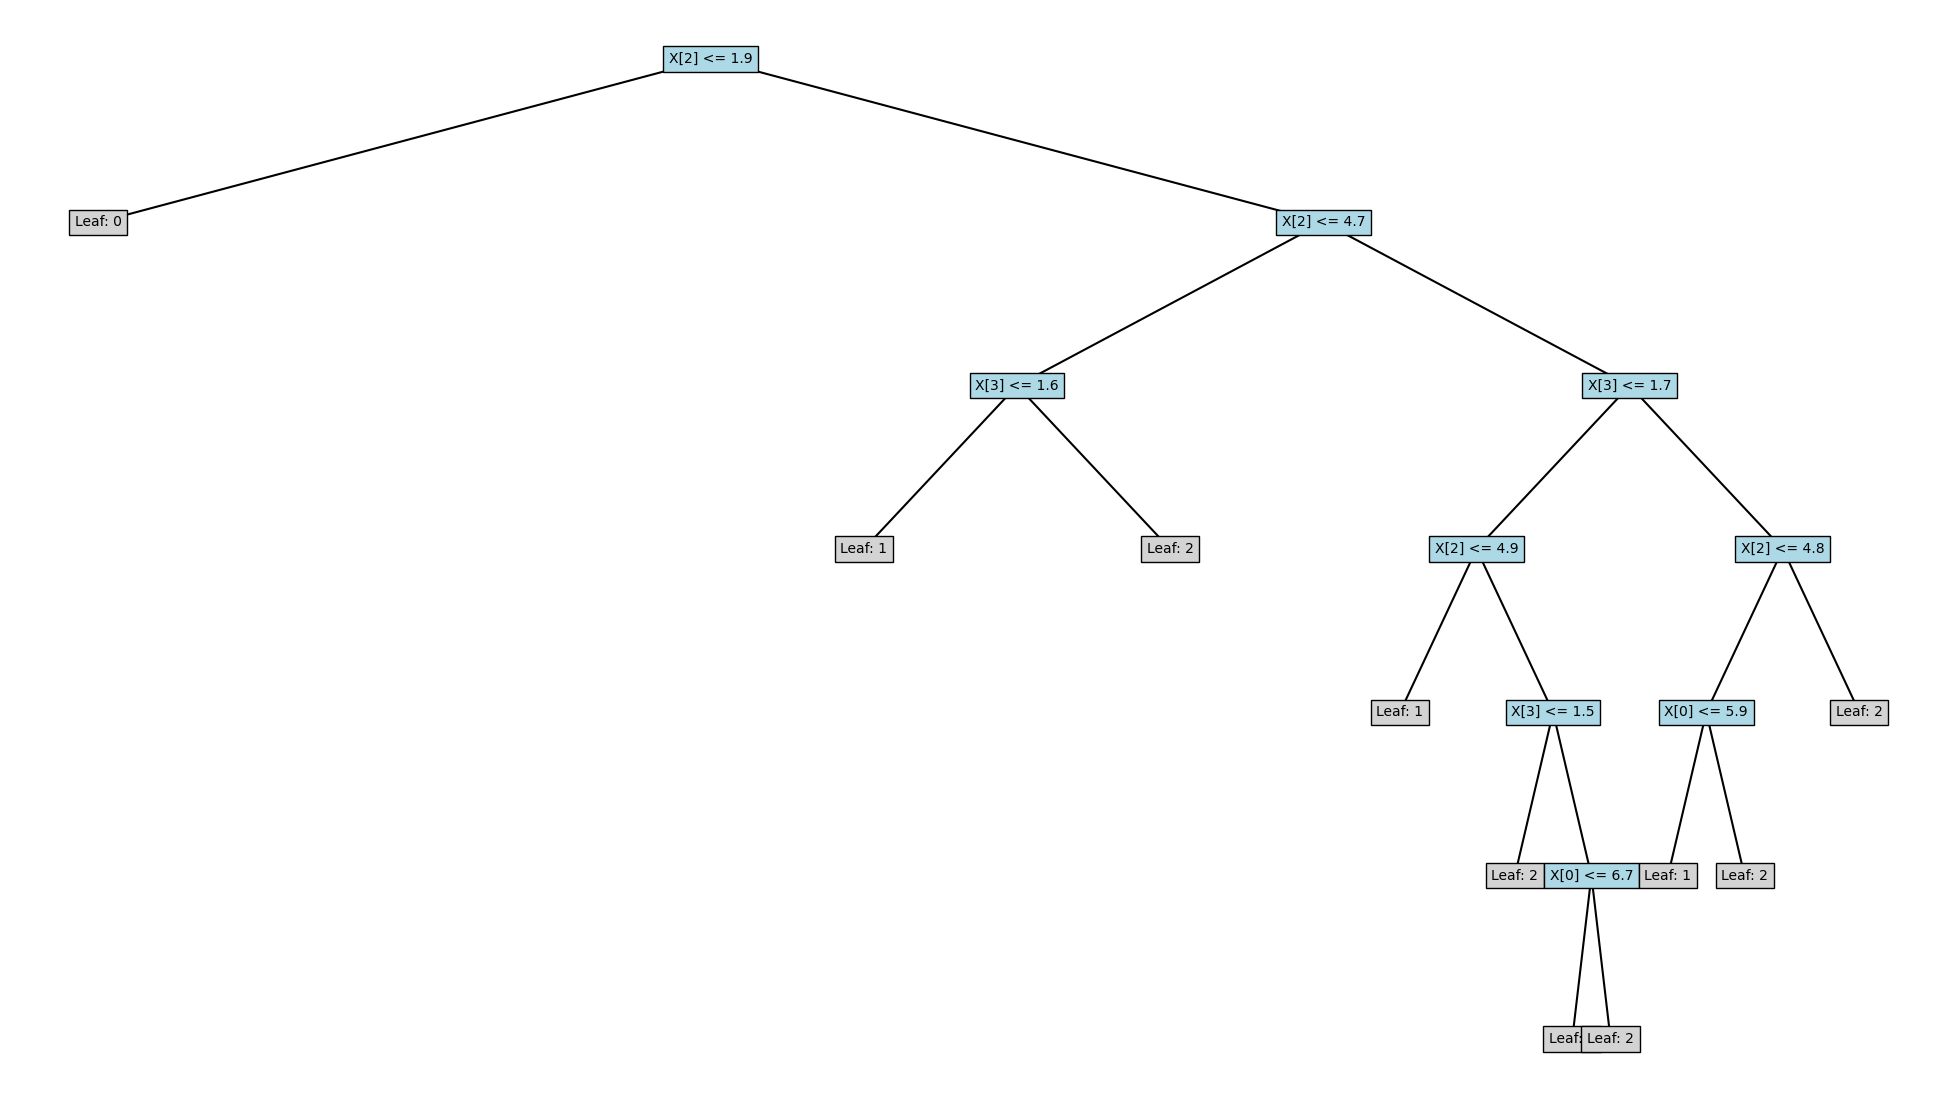

In [29]:
base_model.plot_tree()

In [31]:
class RandomForest:
    def __init__(self,n_estimators = 10, max_depth = 5, min_samples_split = 2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def _bootstrap_sample(self,x,y):
        n_samples = x.shape[0]
        shuffle = np.random.choice(n_samples,n_samples, replace = True)
        return x[shuffle], y[shuffle]

    def fit(self,x,y):
        self.trees = []
        for tree in range (self.n_estimators):
            tree = DecisionTree(max_depth = self.max_depth, min_samples_split = self.min_samples_split)
            x_sample, y_sample = self._bootstrap_sample(x,y)
            tree.fit(x_sample, y_sample)
            self.trees.append(tree)

    def predict(self, x):
        tree_pred = np.array([tree.predict(x) for tree in self.trees])
        y_pred = [Counter(tp).most_common(1)[0][0] for tp in tree_pred.T]
        return np.array(y_pred)

    def plot_tree(self):
        for i, tree in enumerate(self.trees):
            print(i+1)
            tree.plot_tree()

In [33]:
def train_test_split(x, y, test_size=0.2, random_state=42):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.permutation(len(x))
    test_size = int(len(x) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return x[train_indices], x[test_indices], y[train_indices], y[test_indices]

In [35]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [37]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris['data']
y = iris['target']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [41]:
base_model = RandomForest(max_depth=5, min_samples_split=2)
base_model.fit(x_train, y_train)

Selected feature 2 with threshold 1.9 as a decision node
Selected feature 0 with threshold 4.3 as a decision node
Selected feature 3 with threshold 1.7 as a decision node
Selected feature 3 with threshold 1.4 as a decision node
Selected feature 0 with threshold 5.0 as a decision node
Selected feature 1 with threshold 2.8 as a decision node
Selected feature 0 with threshold 6.3 as a decision node
Selected feature 0 with threshold 4.9 as a decision node
Selected feature 0 with threshold 5.6 as a decision node
Selected feature 0 with threshold 5.6 as a decision node
Selected feature 2 with threshold 1.9 as a decision node
Selected feature 0 with threshold 4.3 as a decision node
Selected feature 2 with threshold 4.7 as a decision node
Selected feature 0 with threshold 4.9 as a decision node
Selected feature 2 with threshold 4.8 as a decision node
Selected feature 0 with threshold 5.9 as a decision node
Selected feature 0 with threshold 5.6 as a decision node
Selected feature 2 with thresho

In [43]:
y_pred = base_model.predict(x_test)

In [45]:
acc = accuracy(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 1.0


1
2
3
4
5
6
7
8
9
10


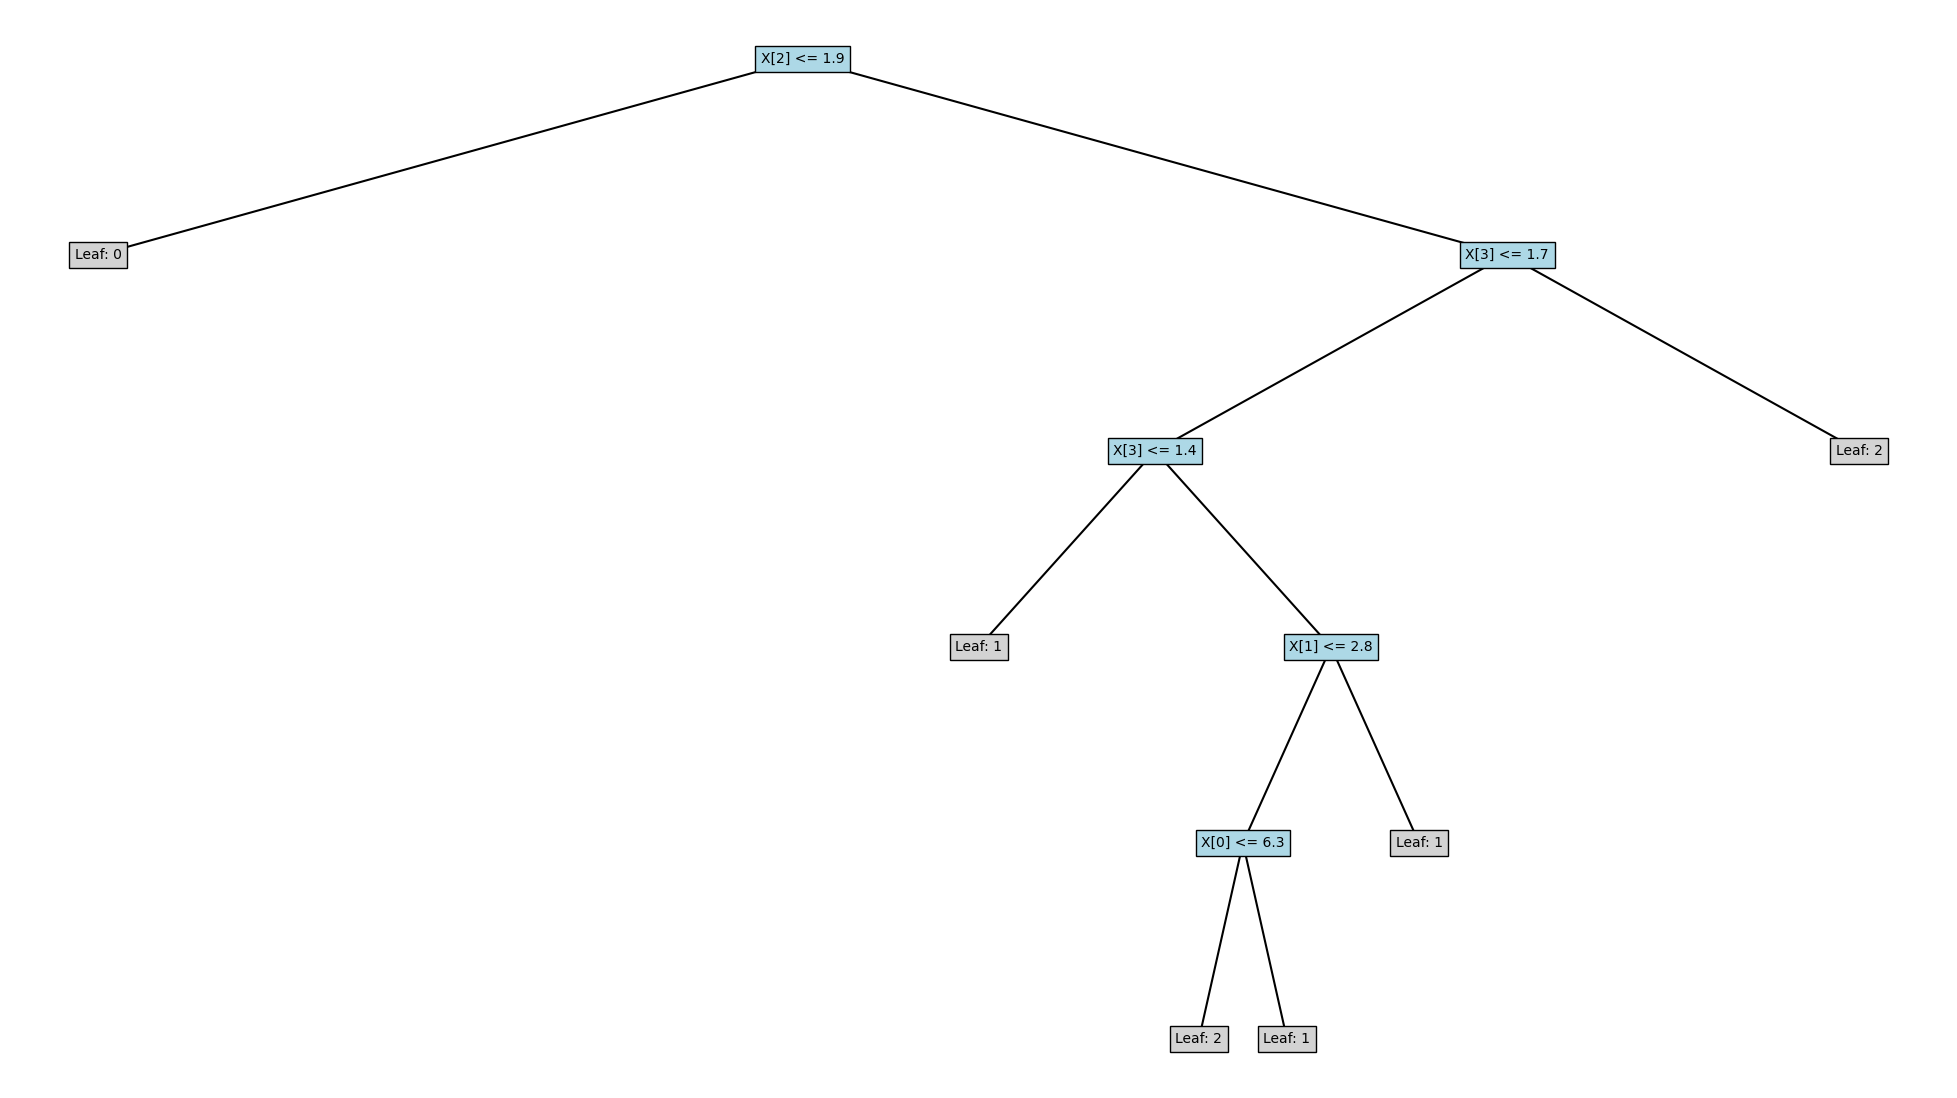

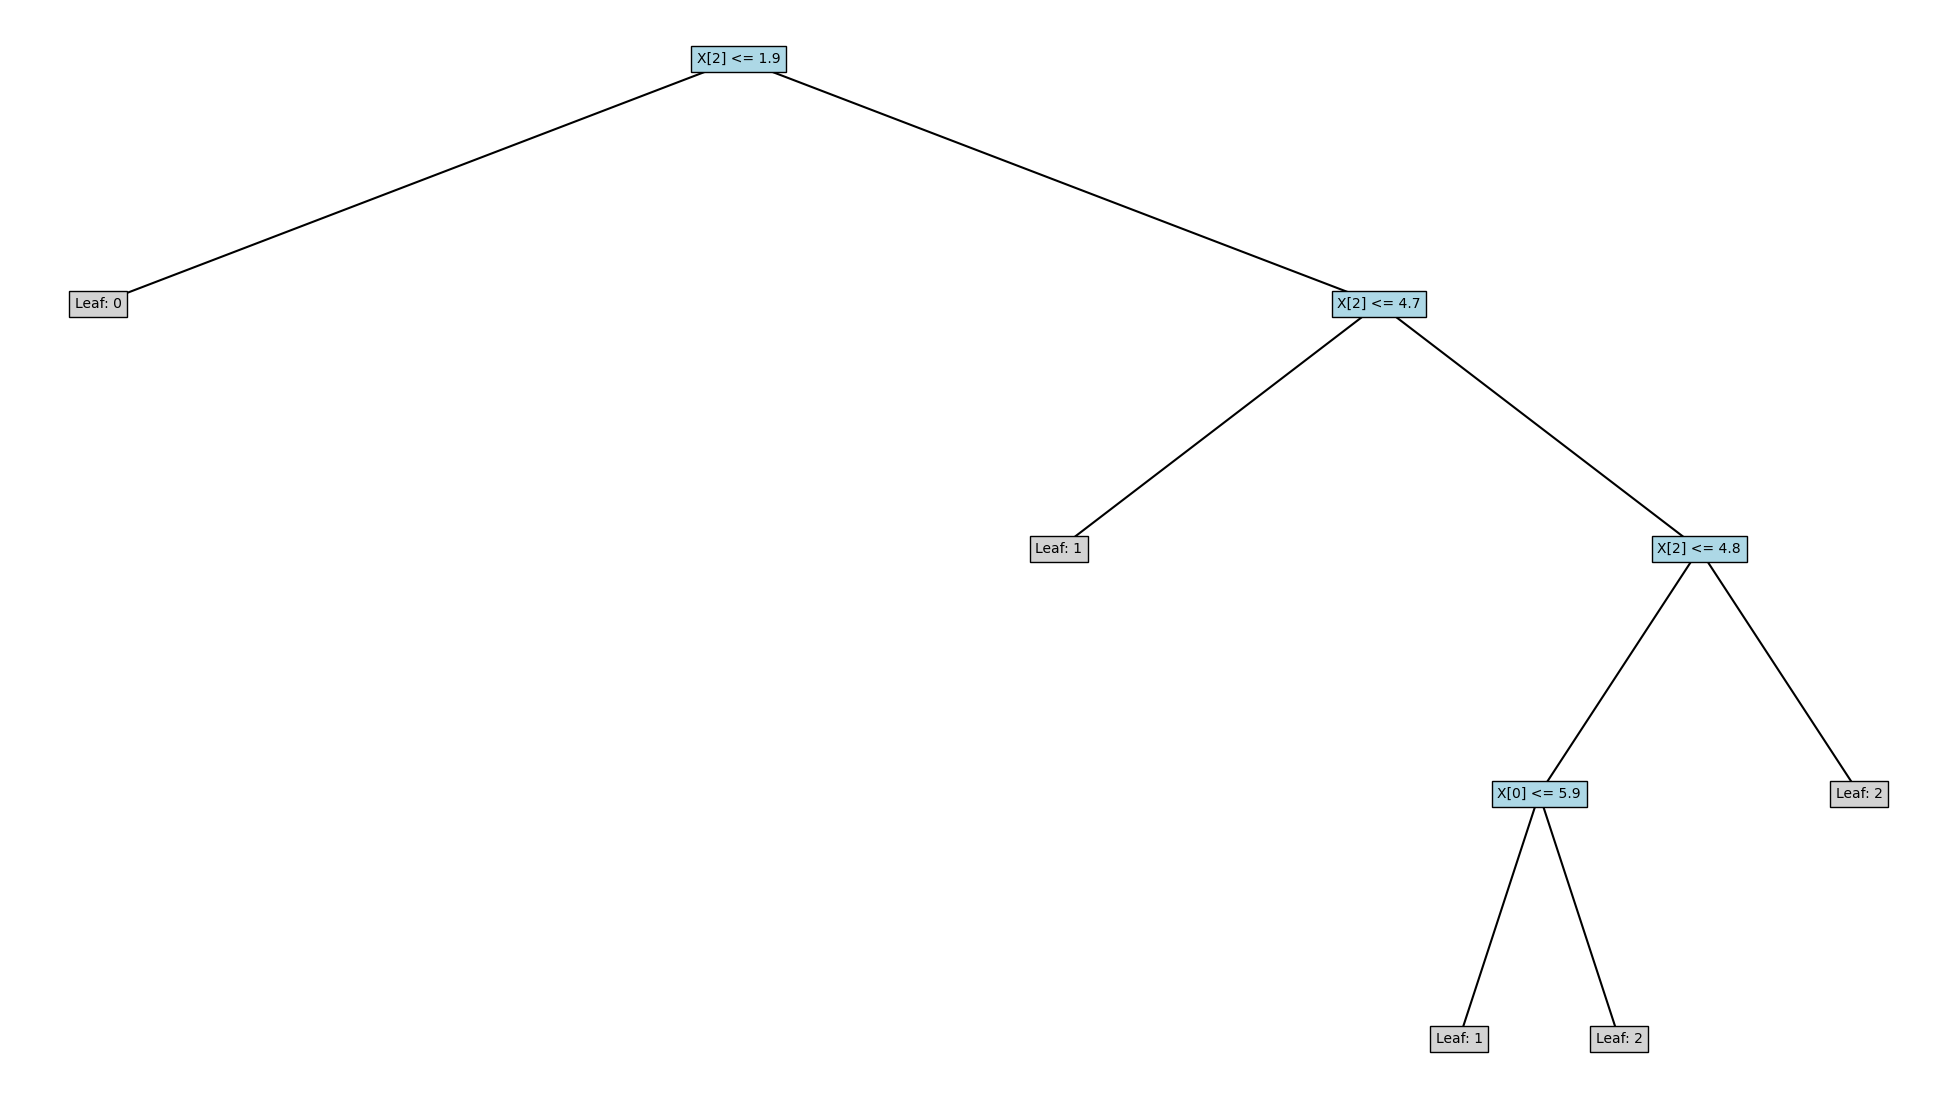

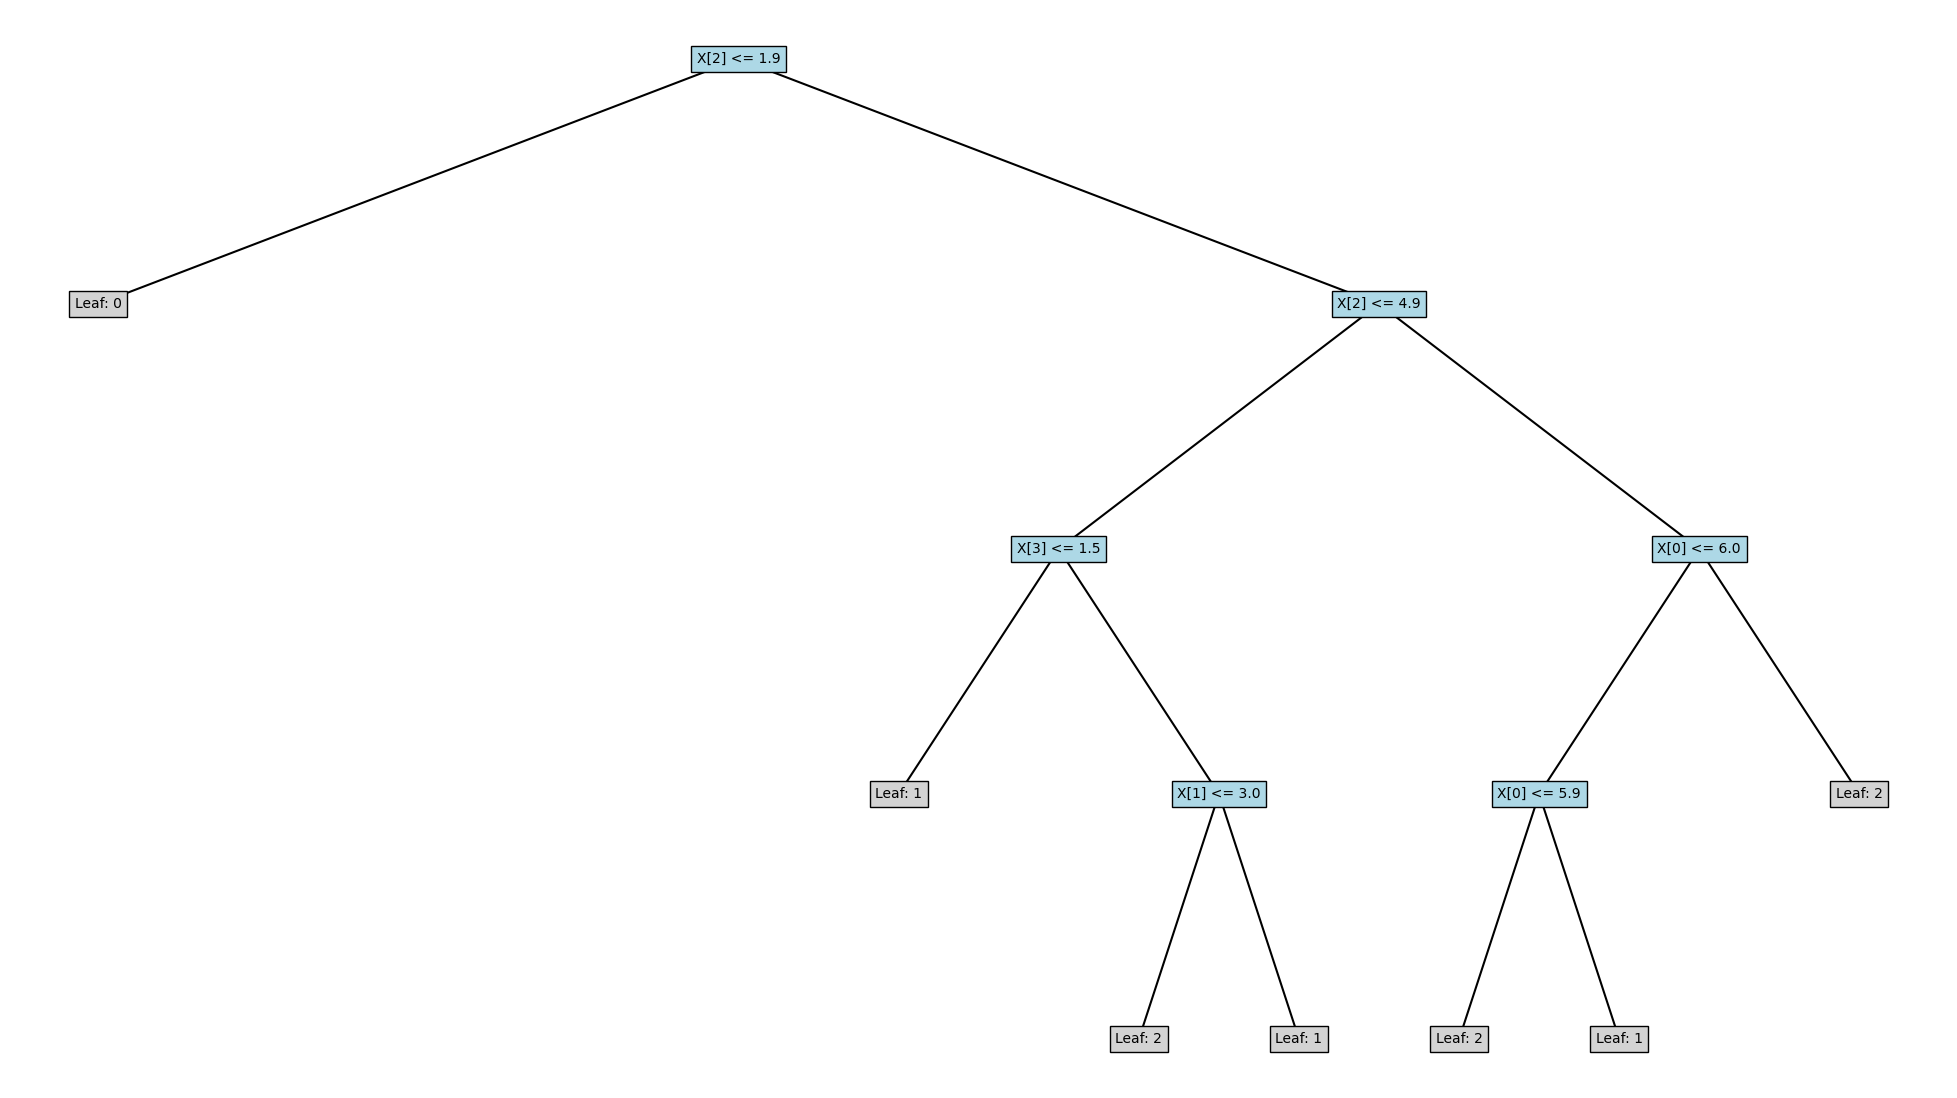

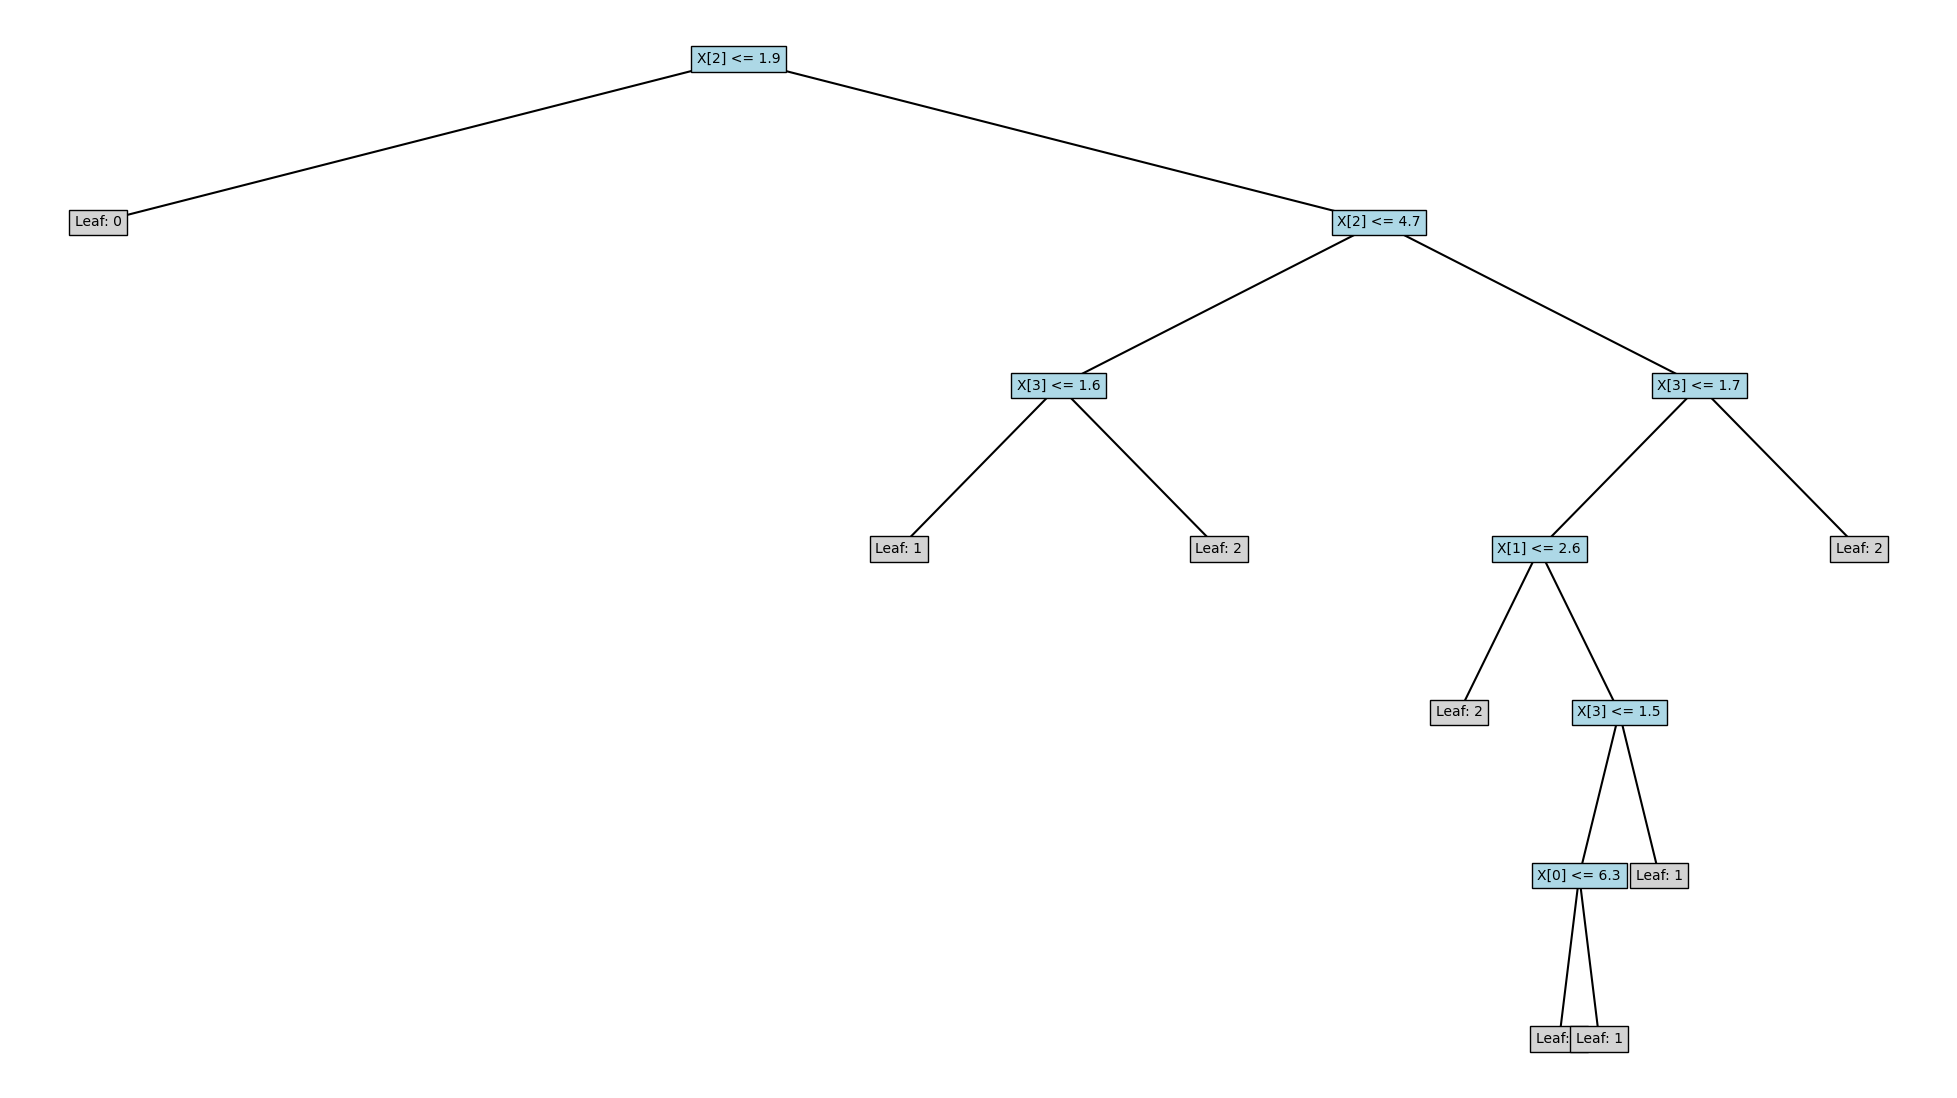

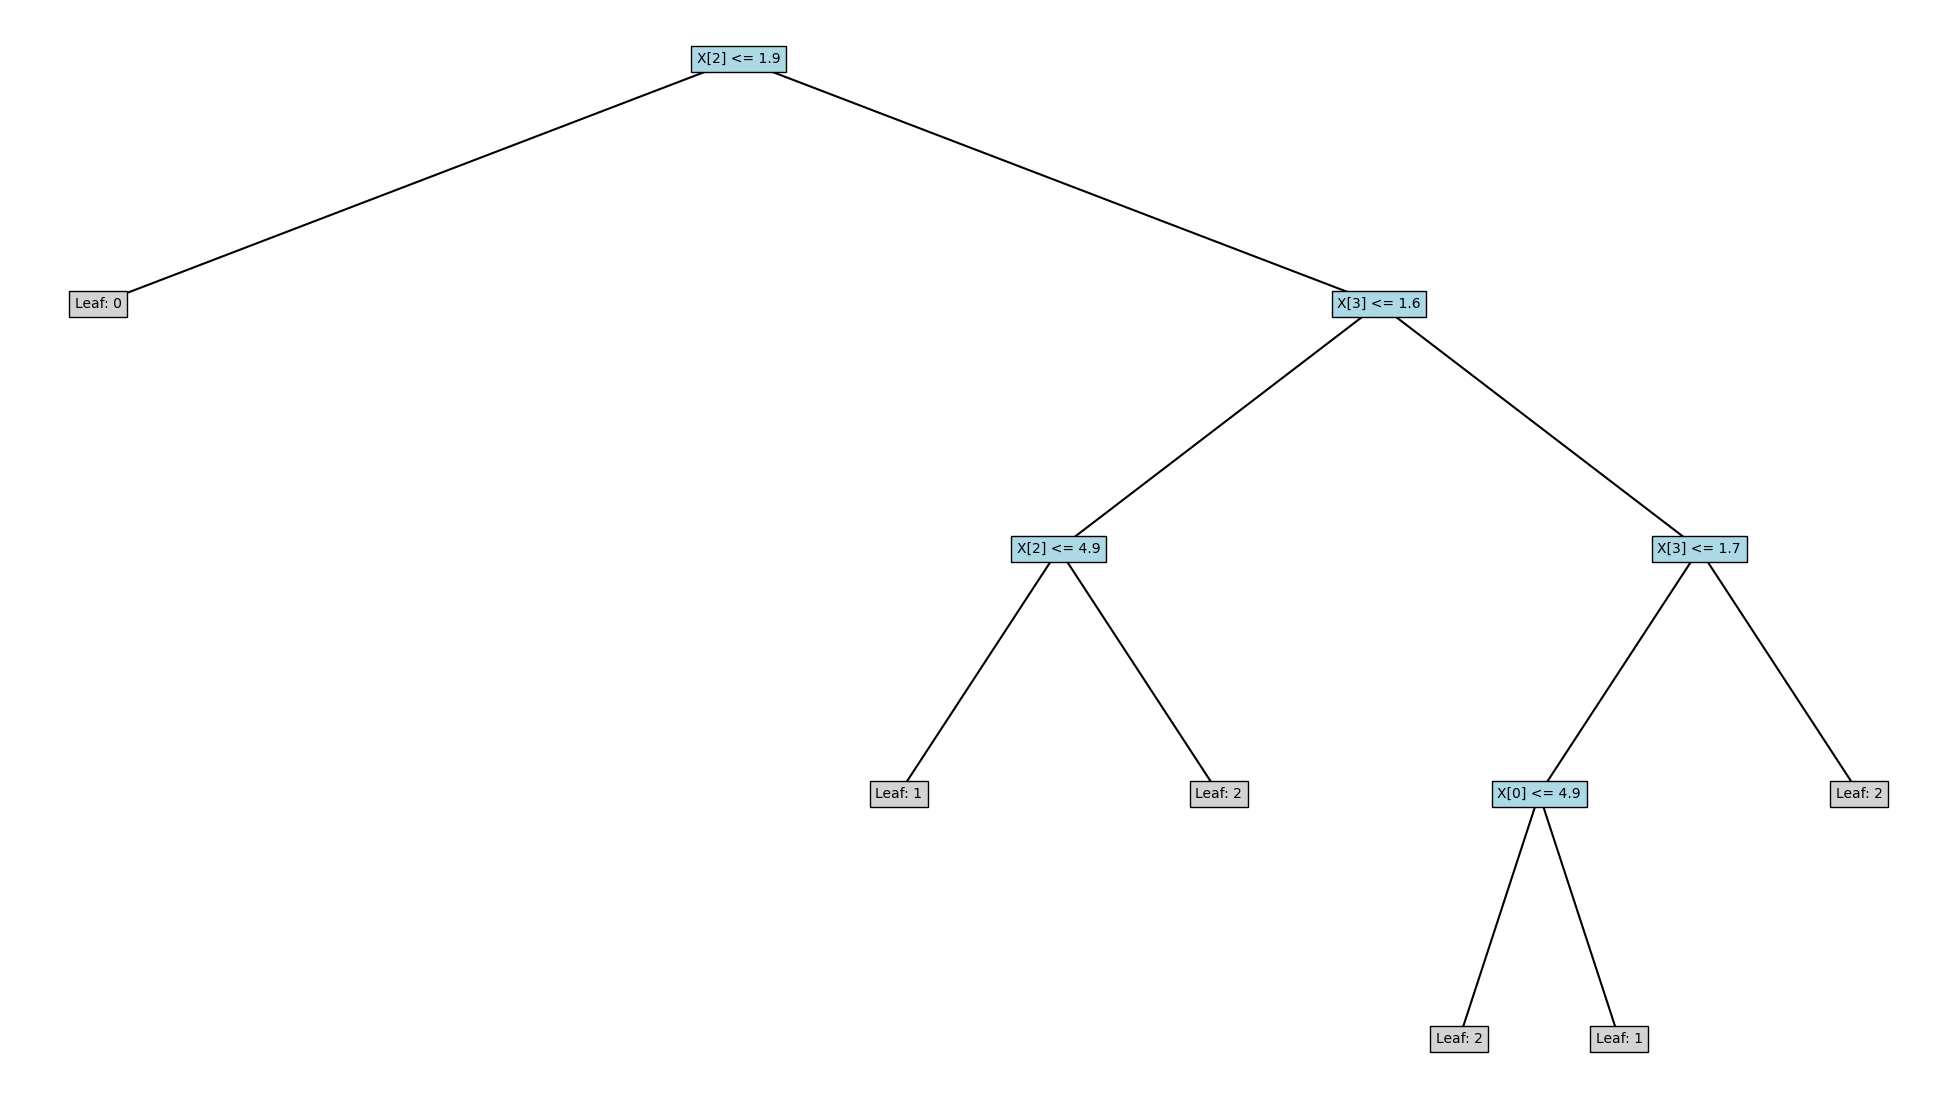

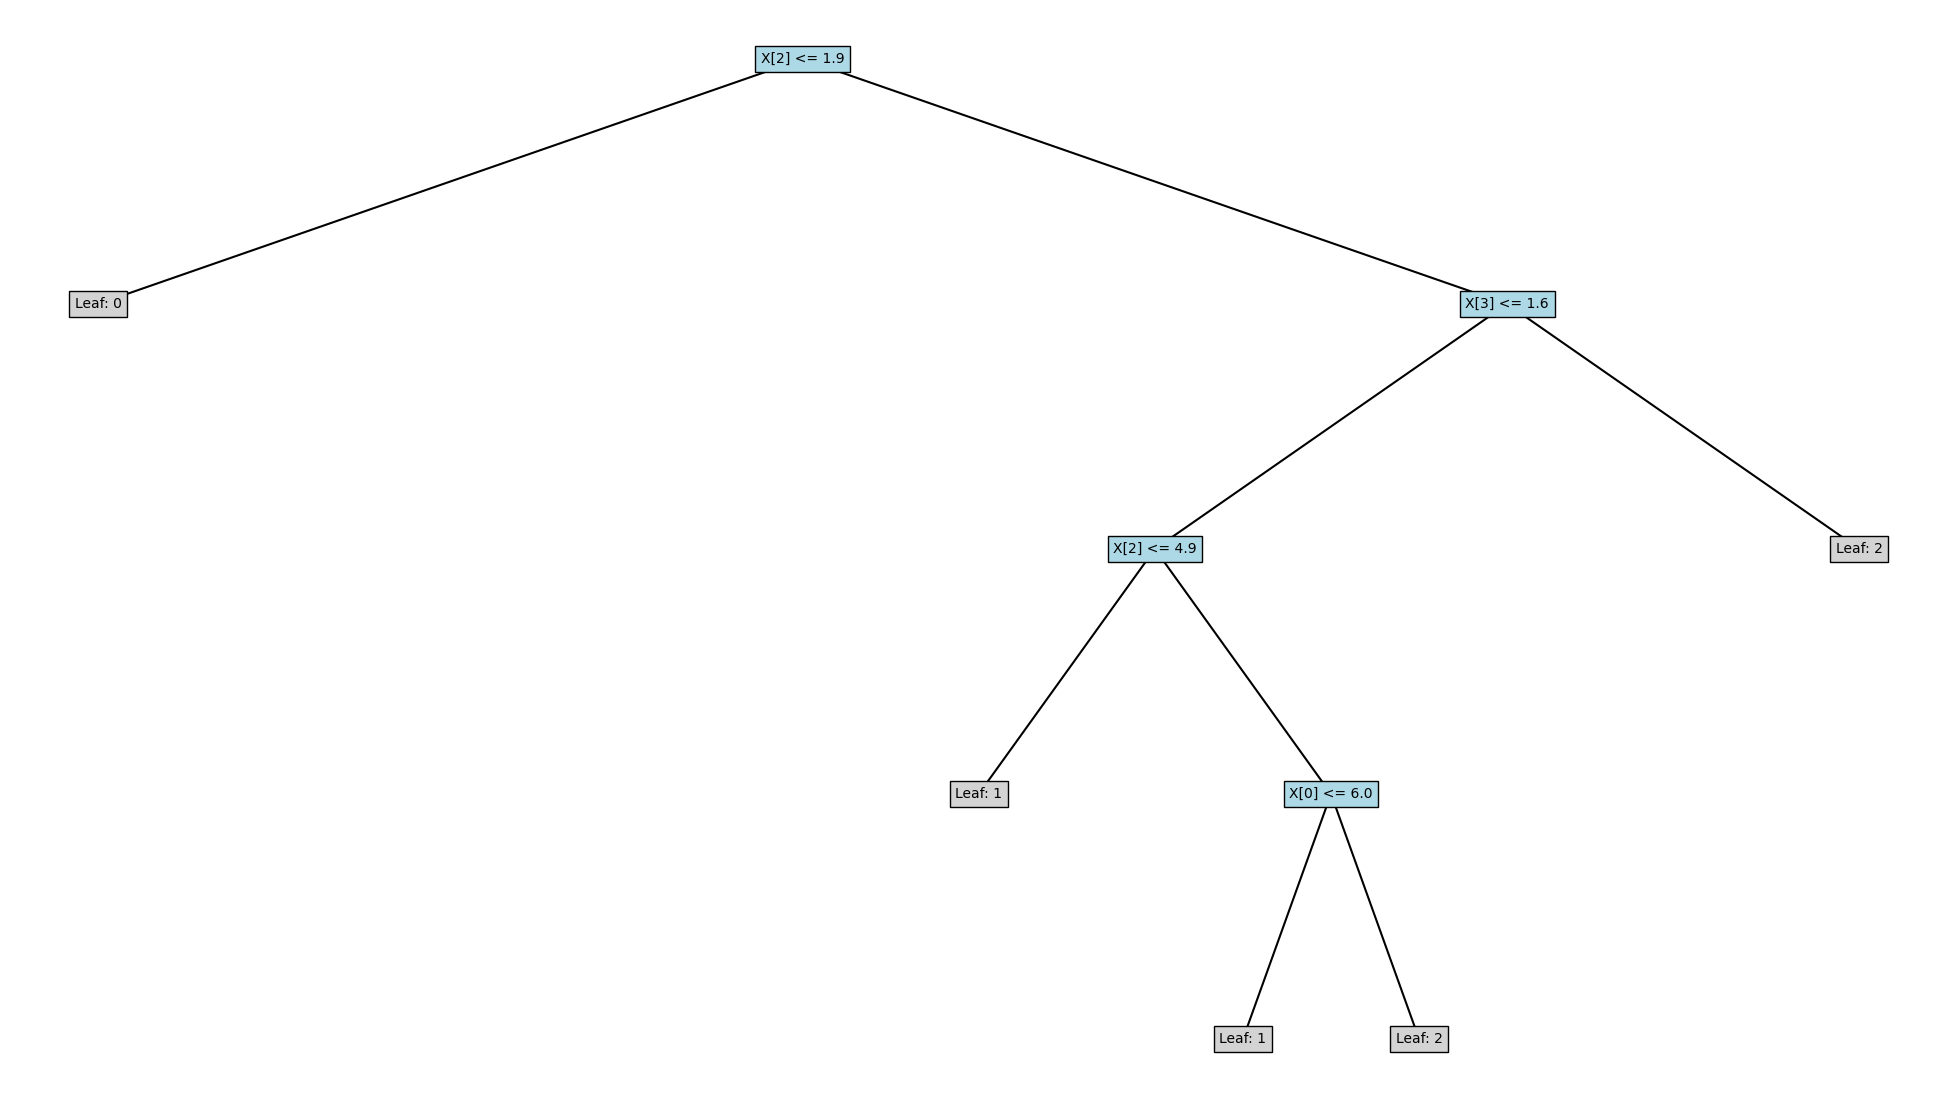

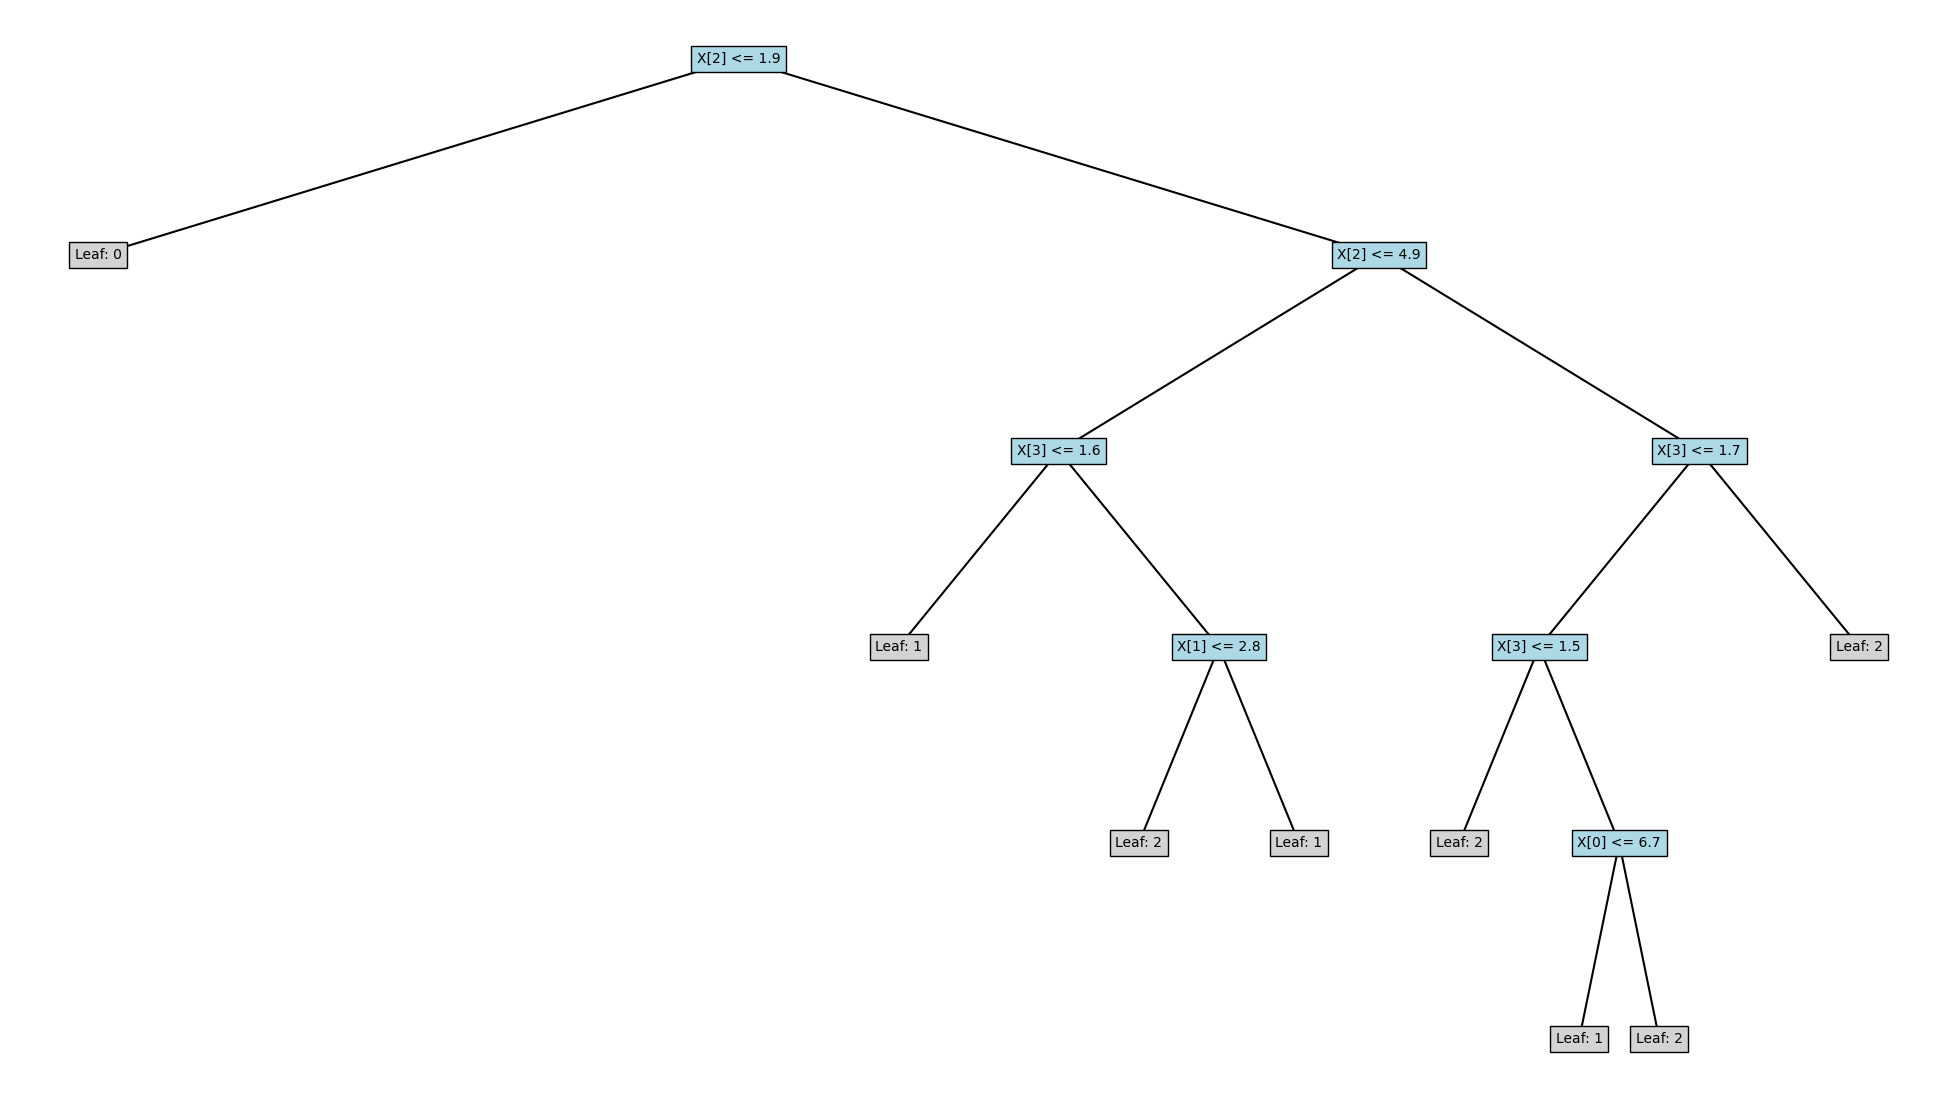

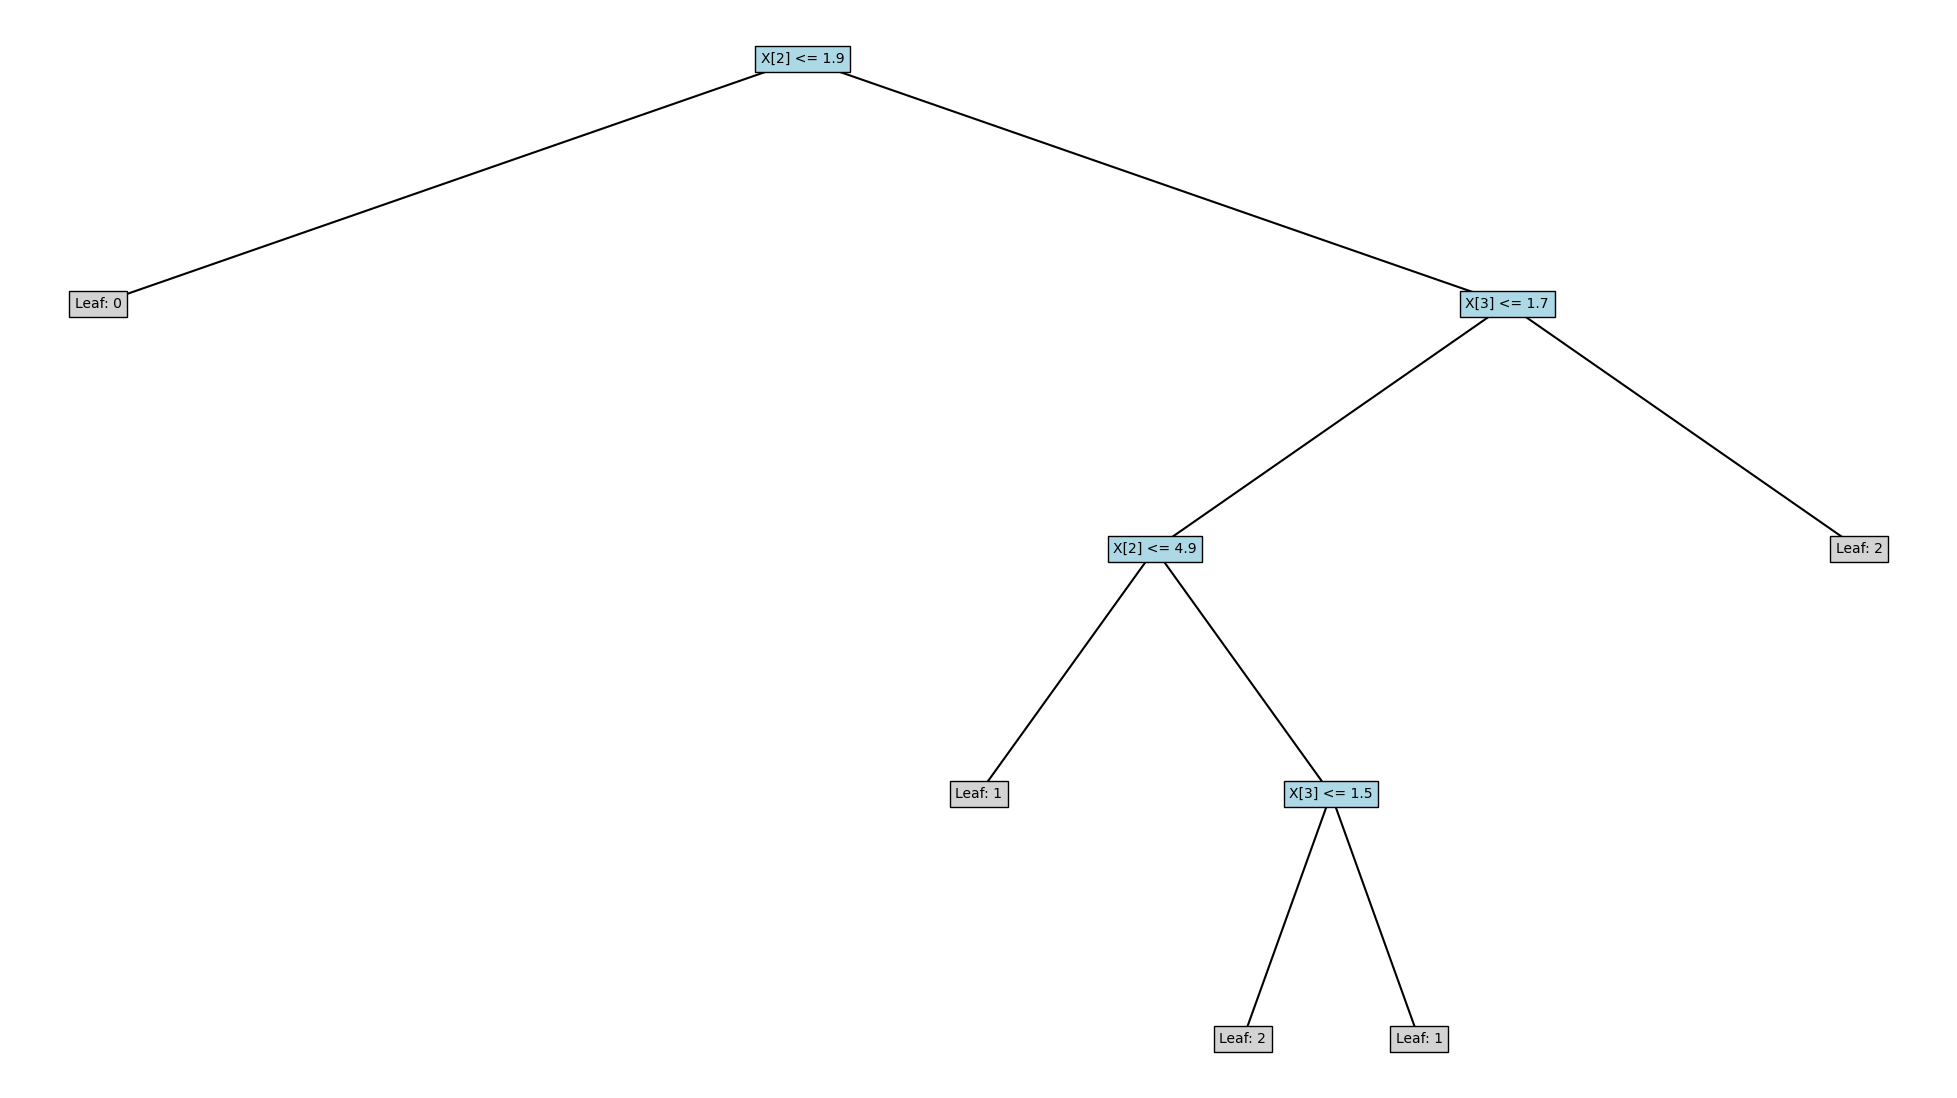

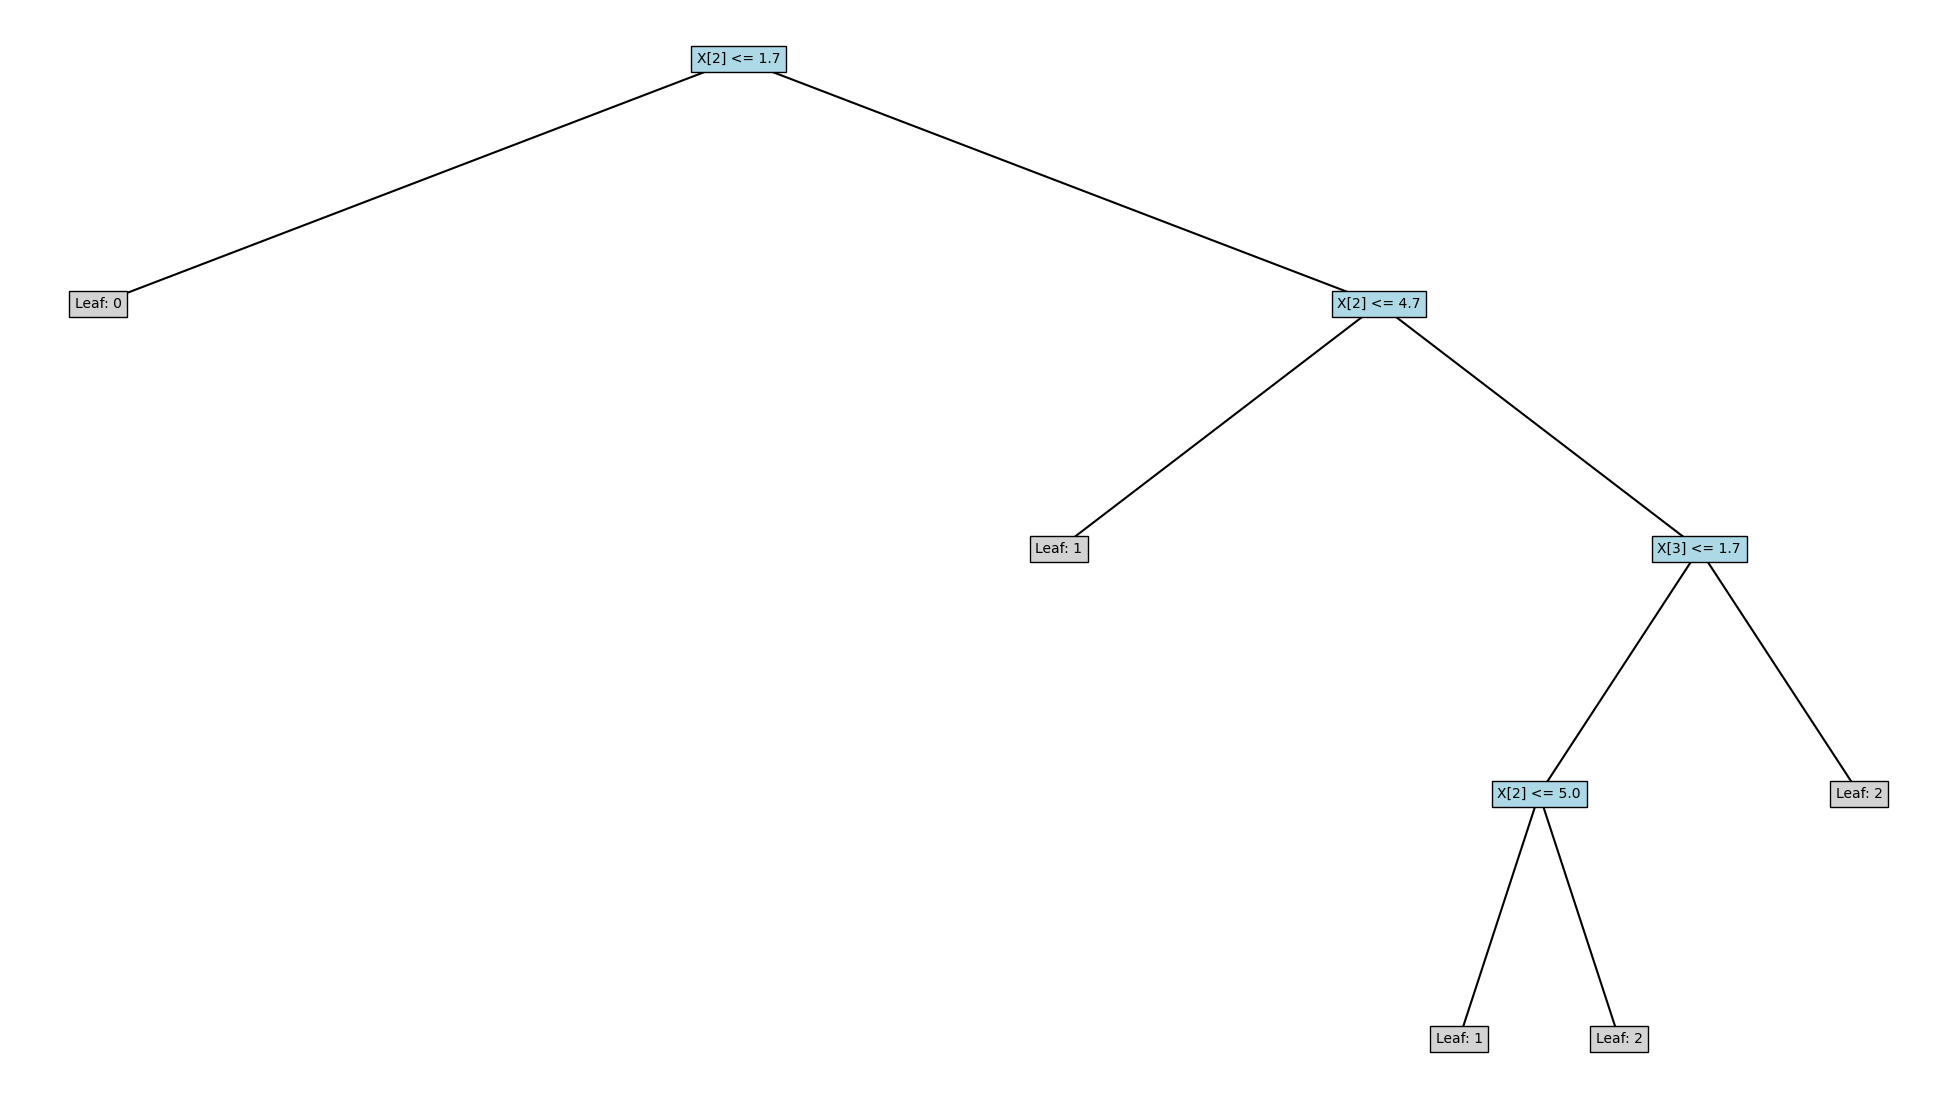

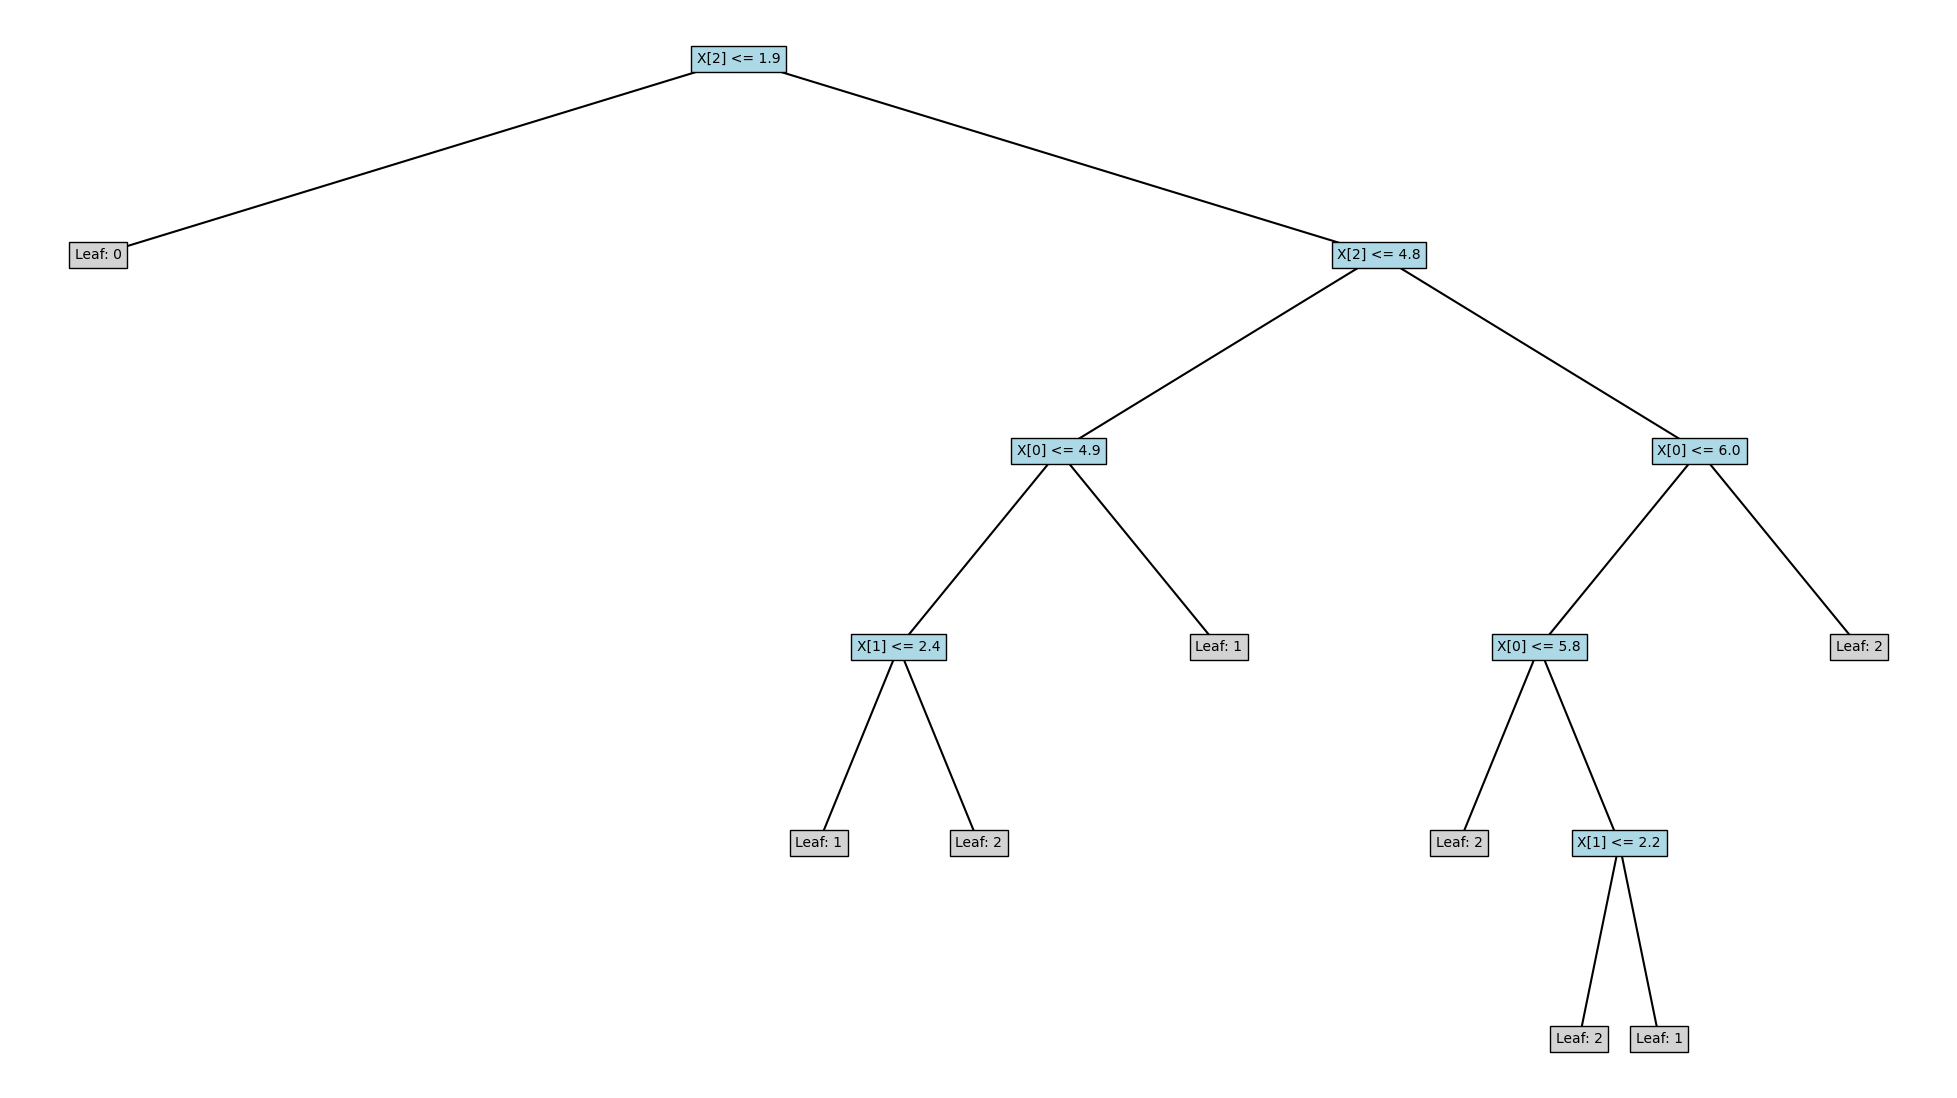

In [47]:
base_model.plot_tree()